In [179]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('synthetic_payu_sample_2000.csv')

In [3]:
df.head()

,timestamp,method,amount,status,settlement_time_s,date,period
0,2025-02-27 22:15:42,Card,1254.1700,Success,8,2025-02-27,before
1,2025-01-16 08:32:48,UPI,477.9500,Success,6,2025-01-16,before
2,2025-07-07 22:56:32,Netbanking,484.2500,Success,7,2025-07-07,after
3,2025-07-16 09:22:35,UPI,1585.6365,Success,5,2025-07-16,after
4,2025-03-09 07:58:46,UPI,507.5300,Success,3,2025-03-09,before


In [4]:
df.shape

(2000, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          2000 non-null   object 
 1   method             2000 non-null   object 
 2   amount             2000 non-null   float64
 3   status             2000 non-null   object 
 4   settlement_time_s  2000 non-null   int64  
 5   date               2000 non-null   object 
 6   period             2000 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 109.5+ KB


In [12]:
df['date'] = pd.to_datetime(df['date'])
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S')

In [25]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          2000 non-null   datetime64[ns]
 1   method             2000 non-null   category      
 2   amount             2000 non-null   float64       
 3   status             2000 non-null   category      
 4   settlement_time_s  2000 non-null   int64         
 5   date               2000 non-null   datetime64[ns]
 6   period             2000 non-null   category      
dtypes: category(3), datetime64[ns](2), float64(1), int64(1)
memory usage: 68.9 KB


In [35]:
upi = df[df['method'] == 'UPI']['amount']
card = df[df['method'] == 'Card']['amount']

# Problem Statement

- We want to investigate whether customers who pay through UPI spend the same amount, on average, as those who pay through Card.
- Even though both are popular payment modes, there may be a difference in spending behavior.
- The goal is to statistically test if this difference in mean transaction amounts is real (significant) or just due to random variation.

## What We Asked
1. Do UPI users and Card users spend the same on average, or is there a difference?
2. In other words: Is the higher Card mean (₹738 vs ₹513) just due to random sample variation, or is it a true population difference?

## Hypothesis Setup
#### Null Hypothesis (H₀):
- mean UPI = mean Card
- (Mean spend of UPI and Card users is equal.)
#### Alternative Hypothesis (H₁):
- mean UPI != mean Card
- (Mean spend of UPI and Card users is not equal.)

In [47]:
upi_mean,card_mean = upi.mean(),card.mean()
print('UPI mean {} \nCard mean {}'.format(upi_mean,card_mean))

UPI mean 512.8585196531792 
Card mean 738.1208299319728


In [45]:
t_stat,p_val = stats.ttest_ind(upi,card,equal_var=False)
print('t_stat {} \np_value {}'.format(t_stat,p_val))

t_stat -11.810717987131882 
p_value 1.0100812526099393e-30


In [48]:
cohen_d = (upi.mean() - card.mean())/np.sqrt((upi.var()+card.var())/2)
print(cohen_d)

-0.5985614254042617


### Results
- UPI mean = ₹512.86
- Card mean = ₹738.12
- t-statistic = -11.81
- p-value = 1.01e-30 (< 0.05)
- Cohen’s d = -0.60 (medium-to-large effect)

#### Interpretation
- Since p < 0.05, we reject H₀.
- The probability of this difference happening by chance is almost zero.
- Cohen’s d = -0.60 → UPI mean is lower than Card mean, and the difference is meaningful in practice.

#### Final Conclusion
- UPI and Card means are not equal (H₁ accepted).
- Card users spend ~44% more per transaction than UPI users.
- The difference is statistically significant and practically important.

### We already see Card > UPI in means, but hypothesis testing proves that this difference is statistically significant and not due to random chance. This gives confidence that Card transactions truly generate more revenue in the population, not just in our sample

#### What we achieved from the test

- We compared mean transaction amounts between UPI and Card users.
- Card mean = ₹738 and UPI mean = ₹513 → Card users spend ~43.9% more per transaction.
- The p-value < 0.05 → the difference is statistically significant, not due to random chance.
- Cohen’s d ≈ -0.6 → medium effect size → the difference is practically meaningful.

#### Advice to the company

- Encourage Card Payments: Since Card users spend more per transaction, the company can promote card usage (e.g., discounts, reward points, EMI offers).
- UPI Strategy: UPI is more popular in India due to ease, but spends are lower. The company can design campaigns to increase UPI ticket size (e.g., cashback for higher spend tiers like “Get ₹50 cashback on spends above ₹1,000”).
- Segmentation: Different spending behaviors show two distinct customer segments. The company can tailor offers separately:
- UPI: focus on increasing volume of transactions.
- Card: focus on maximizing value per transaction.
- Revenue Growth: By nudging UPI users to increase spend, or attracting more card users, the company can boost overall revenue.

# Loan Recovery Analysis – Digital vs Manual Channels

In [79]:
collection_df = pd.read_csv('Collection data.csv')

In [80]:
collection_df.shape

(10000, 6)

In [81]:
collection_df.drop(columns=['Unnamed: 0'],inplace=True)

In [82]:
collection_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      10000 non-null  int64  
 1   LoanType        10000 non-null  object 
 2   Channel         10000 non-null  object 
 3   RecoveryAmount  10000 non-null  float64
 4   RecoveryDate    10000 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 390.8+ KB


In [93]:
collection_df.columns = collection_df.columns.str.lower()

In [97]:
collection_df.columns

Index(['customerid', 'loantype', 'channel', 'recoveryamount', 'recoverydate'], dtype='object')

In [98]:
collection_df['recoverydate'] = pd.to_datetime(collection_df['recoverydate'])

In [99]:
for i in collection_df.select_dtypes(include='object'):
    collection_df[i] = collection_df[i].astype('category')

In [109]:
# Separate by channel
digital = collection_df[collection_df['channel']=='Digital']['recoveryamount']
manual = collection_df[collection_df['channel']=='Manual']['recoveryamount']

In [110]:
print(digital.mean())

8291.620643985727


In [111]:
print(manual.mean())

7061.25374466917


In [112]:
# Perform two-sample t-test
t_stat, p_val = stats.ttest_ind(digital, manual, equal_var=False)
print('t_stat {} \np_vale {}'.format(t_stat, p_val))

t_stat 18.887537347833007 
p_vale 4.142112507600935e-78


In [113]:
mean_diff = digital.mean() - manual.mean()

In [114]:
# Pooled Standard Deviation (pooled_std)
pooled_std = np.sqrt(((len(digital)-1)*digital.var(ddof=1)+(len(manual)-1)*manual.var(ddof=1))/(len(digital)+len(manual)-1))

In [116]:
#Cohen’s d (Effect Size)
cohena_d = mean_diff/pooled_std
print(cohena_d)

0.3767943001194105


In [129]:
results = {
    'Digital Mean' : [round(digital.mean(),2)],
    'Manual Mean' : [round(manual.mean(),2)],
    'Mean Diff' : [round(mean_diff,2)],
    't - statistic' : [round(t_stat,2)],
    'p - Value' : [round(p_val,100)],
    "Cohen's d" : [round(cohena_d,4)]
}

In [130]:
pd.DataFrame(results)

,Digital Mean,Manual Mean,Mean Diff,t - statistic,p - Value,Cohen's d
0,8291.62,7061.25,1230.37,18.89,4.142113e-78,0.3768


# Loan Recovery Analysis – Digital vs Manual Channels

## 1. What We Asked
- Is there a significant difference in the **average recovery amount** between **Digital (UPI/NetBanking/Auto-debit)** and **Manual (Cash/Cheque/Field)** channels?
- Or is the observed difference just due to **random variation** in our sample?

---

## 2. Hypotheses
- **Null Hypothesis (H₀):**
  μDigital = μManual  
  (Mean recovery amount from Digital and Manual channels is equal.)

- **Alternative Hypothesis (H₁):**
  μDigital ≠ μManual  
  (Mean recovery amounts are not equal → a difference exists.)

---

## 3. Results
- Digital mean = ₹8,291.62  
- Manual mean = ₹7,061.25  
- Difference = ₹1,230.37 (~17.4% higher for Digital)  
- t-statistic = 18.89  
- p-value = 4.14e-78 (< 0.05)  
- Cohen’s d = 0.38 (small-to-medium effect size)

---

## 4. Interpretation
- Since **p < 0.05**, we **reject H₀**.  
- Digital recoveries are **significantly higher** than Manual recoveries.  
- Cohen’s d = 0.38 → the effect is **moderate**, meaning it is practically meaningful.

---

## 5. Advice to the Company
1. **Promote Digital Repayments** → Encourage UPI, NetBanking, Auto-debit since they yield **higher recovery amounts**.  
2. **Optimize Field Efforts** → Reduce dependency on costly manual collections except where digital adoption is low.  
3. **Cost Efficiency** → Digital channels recover more and also **reduce operational costs**.  
4. **Customer Incentives** → Offer rewards/cashback for digital repayments to increase adoption.  

---

📌 **Final Statement:**  
Digital recoveries are **~17% higher** than manual recoveries, with the difference being **statistically significant (p < 0.05)** and **practically meaningful (Cohen’s d = 0.38)**.  
The company should **push digital repayment adoption** to maximize recovery and reduce costs.


# Analysis: Calls vs Recovery

In [155]:
dialer_data = pd.read_csv('Dailer Data.csv')
df = dialer_data.copy()

In [156]:
df['DueDate'] = pd.to_datetime(df['DueDate'])
df['PaymentDate'] = pd.to_datetime(df['PaymentDate'])

In [157]:
dialer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      20000 non-null  int64  
 1   CallsMade       20000 non-null  int64  
 2   PaymentStatus   20000 non-null  int64  
 3   RecoveryAmount  20000 non-null  float64
 4   DueDate         20000 non-null  object 
 5   PaymentDate     20000 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 937.6+ KB


In [158]:
# Add DelayDays (PaymentDate - DueDate). If not paid, set NaN for delay
df['DelayDays'] = (pd.to_datetime(df['PaymentDate']) - pd.to_datetime(df['DueDate'])).dt.days
df.loc[df['PaymentStatus'] == 0, 'DelayDays'] = np.nan

In [160]:
# Summary by CallsMade
summary = df.groupby('CallsMade').agg(
    customers = ('CustomerID','count'),
    recovered = ('PaymentStatus','sum'),
    recovery_rate = ('PaymentStatus',lambda x:x.mean()),
    avg_recovery_amount = ('RecoveryAmount', lambda x : x[x>0].mean() if (x>0).any() else 0),
    avg_delay_days = ('DelayDays','mean')).reset_index().sort_values('CallsMade')

In [161]:
summary

,CallsMade,customers,recovered,recovery_rate,avg_recovery_amount,avg_delay_days
0,0,1867,546,0.292448,4972.725709,-0.468864
1,1,1822,745,0.408891,5150.151412,1.998658
2,2,1825,919,0.503562,5363.307093,2.046790
3,3,1801,1078,0.598556,5638.094406,2.016698
4,4,1804,1301,0.721175,5844.695117,5.543428
5,5,1846,1477,0.800108,5979.839632,5.523358
6,6,1836,1659,0.903595,6242.013969,5.503918
7,7,1812,1630,0.899558,6442.099046,5.500613
8,8,1789,1607,0.898267,6607.456652,9.504667
9,9,1890,1685,0.891534,6785.714499,9.579822


### Chi-Square test: callMade (0-10) vs Payment statuses

In [163]:
ct = pd.crosstab(df['CallsMade'],df['PaymentStatus'])
ct

PaymentStatus,0,1
CallsMade,,
0,1321,546
1,1077,745
2,906,919
3,723,1078
4,503,1301
5,369,1477
6,177,1659
7,182,1630
8,182,1607


In [165]:
chi2,p_chi,dof,excepted = stats.chi2_contingency(ct.values)
print('chi2 {} \np_chi {} \ndof {} \nexcepted {}'.format(chi2,p_chi,dof,excepted))

chi2 4507.667678361766 
p_chi 0.0 
dof 10 
excepted [[ 542.45685 1324.54315]
 [ 529.3821  1292.6179 ]
 [ 530.25375 1294.74625]
 [ 523.28055 1277.71945]
 [ 524.1522  1279.8478 ]
 [ 536.3553  1309.6447 ]
 [ 533.4498  1302.5502 ]
 [ 526.4766  1285.5234 ]
 [ 519.79395 1269.20605]
 [ 549.1395  1340.8605 ]
 [ 496.2594  1211.7406 ]]


# Chi-square Test: CallsMade vs PaymentStatus

#### 1. What We Asked
- Does the **number of calls** made to a customer affect whether they **pay (PaymentStatus)**?
- Or in other words: *Are CallsMade and PaymentStatus independent, or related?*


#### 2. Hypotheses
- **Null Hypothesis (H₀):** CallsMade and PaymentStatus are independent.  
  (Number of calls has no effect on whether payment is made.)  

- **Alternative Hypothesis (H₁):** CallsMade and PaymentStatus are dependent.  
  (Number of calls influences payment outcome.)  

#### 3. Results
- Chi² statistic = 4507.67  
- p-value ≈ 0.0 (< 0.05)  
- Degrees of freedom (dof) = 10  

**Expected frequencies (if independence was true):**

| CallsMade | Not Paid | Paid    |
|-----------|----------|---------|
| 0         | 542.46   | 1324.54 |
| 1         | 529.38   | 1292.62 |
| 2         | 530.25   | 1294.75 |
| 3         | 523.28   | 1277.72 |
| 4         | 524.15   | 1279.85 |
| 5         | 536.36   | 1309.64 |
| 6         | 533.45   | 1302.55 |
| 7         | 526.48   | 1285.52 |
| 8         | 519.79   | 1269.21 |
| 9         | 549.14   | 1340.86 |
| 10        | 496.26   | 1211.74 |


#### 4. Interpretation
- Since **p < 0.05**, we **reject H₀**.  
- CallsMade and PaymentStatus are **not independent**.  
- The number of calls **significantly affects the chance of recovery**.  


#### 5. Business Insight
- More calls → higher chance of recovery.  
- But diminishing returns after ~6–7 calls (seen in marginal analysis).  
- Therefore: *Number of calls matters, but beyond 7 calls the benefit is very small.*


# ANOVA on Recovery Amount (only recovered customers)

In [168]:
# 3. ANOVA: do recovered amounts differ by CallsMade (only consider recovered rows)
recovered_df = df[df['PaymentStatus']==1].copy()
anova_res = stats.f_oneway(*[recovered_df[recovered_df['CallsMade']==k]['RecoveryAmount'] 
                             for k in sorted(recovered_df['CallsMade'].unique()) if len(recovered_df[recovered_df['CallsMade']==k])>0])
print(anova_res)

F_onewayResult(statistic=np.float64(476.2470060202426), pvalue=np.float64(0.0))


# ANOVA Test: Recovery Amounts vs Number of Calls

### 1. What We Asked
- Do customers who receive **different numbers of calls** have the same **average recovery amount**?
- Or does the average recovery amount **differ significantly** depending on call frequency?

### 2. Hypotheses
- **Null Hypothesis (H₀):**  
  Mean recovery amounts are equal across all call groups.  

- **Alternative Hypothesis (H₁):**  
  At least one call group has a different mean recovery amount.  

### 3. Results
- F-statistic = **476.25**  
- p-value ≈ **0.0 (< 0.05)**  


### 4. Interpretation
- Since **p < 0.05**, we **reject H₀**.  
- This means the **average recovery amount is significantly different across call groups**.  

### 5. Business Insight
- More calls not only increase the **likelihood of recovery** (Chi-square test)   but also increase the **amount recovered on average**.  
- However, earlier analysis showed diminishing returns after ~6–7 calls.  
- Therefore, **optimal call strategy = up to 6–7 calls per customer** for maximum efficiency.

# Marginal Gains and Plateau Analysis

In [169]:
# 4. Marginal gains: incremental recovery rate per extra call
sr = summary[['CallsMade','customers','recovered','recovery_rate']].copy()
sr['recovery_rate_pct'] = sr['recovery_rate']*100
sr = sr.sort_values('CallsMade').reset_index(drop=True)
sr['marginal_pct_point'] = sr['recovery_rate_pct'].diff().fillna(sr['recovery_rate_pct'])

In [172]:
sr

,CallsMade,customers,recovered,recovery_rate,recovery_rate_pct,marginal_pct_point
0,0,1867,546,0.292448,29.244778,29.244778
1,1,1822,745,0.408891,40.889133,11.644355
2,2,1825,919,0.503562,50.356164,9.467032
3,3,1801,1078,0.598556,59.855636,9.499471
4,4,1804,1301,0.721175,72.117517,12.261881
5,5,1846,1477,0.800108,80.010834,7.893318
6,6,1836,1659,0.903595,90.359477,10.348643
7,7,1812,1630,0.899558,89.955850,-0.403627
8,8,1789,1607,0.898267,89.826719,-0.129131
9,9,1890,1685,0.891534,89.153439,-0.673280


# Marginal Gains and Plateau Analysis

### 1. What We Asked
- At what number of calls does the **recovery rate stop improving significantly**?
- We measure the **marginal gain** = increase in recovery rate (percentage points) from one additional call.

### 2. Method
1. Group customers by number of calls made.  
2. Calculate recovery rate (%) for each group.  
3. Compute **marginal gain** = difference in recovery rate between consecutive call groups.  
4. Find the first call level where marginal gain < 1 percentage point → **plateau point**.

### 3. Results (Example from dataset)
| CallsMade | Recovery Rate (%) | Marginal Gain (pp) |
|-----------|-------------------|--------------------|
| 0         | 29.2%             | ---                |
| 1         | 40.9%             | +11.7              |
| 2         | 50.4%             | +9.5               |
| 3         | 59.9%             | +9.5               |
| 4         | 72.1%             | +12.2              |
| 5         | 80.0%             | +7.9               |
| 6         | 90.4%             | +10.3              |
| 7         | 90.0%             | -0.4               |
| 8         | 89.8%             | -0.1               |
| 9         | 89.2%             | -0.6               |
| 10        | 90.3%             | +1.1               |

- **Plateau Point = 7 calls** (first time marginal gain < 1 percentage point).  

### 4. Interpretation
- Recovery rates improve steadily from **0 → 6 calls**.  
- After **7 calls**, the marginal improvement is negligible (even negative at times).  
- **Optimal calling strategy**: cap collection calls at **6–7 per customer**.  

### 5. Business Insight
- Up to 6 calls → strong increase in recovery probability.  
- Beyond 7 calls → minimal benefit but higher cost and customer irritation.  
- Company should **optimize call strategy**:  
  - Routine accounts: stop at 6 calls.  
  - High-value defaults: allow up to 7 calls max.

In [173]:
# Find first CallsMade where marginal gain falls below 1 percentage point
plateau_point = sr.loc[sr['marginal_pct_point'] < 1, 'CallsMade']
plateau = int(plateau_point.iloc[0]) if len(plateau_point)>0 else None
plateau

7

# PaymentStatus ~ CallsMade + CallsMade²

In [176]:
# 5. Logistic regression: PaymentStatus ~ CallsMade + CallsMade^2 (to capture non-linearity)
df['CallsMade_sq'] = df['CallsMade']**2
model = smf.logit("PaymentStatus ~ CallsMade + CallsMade_sq", data=df).fit(disp=False)
# Get marginal effects at mean
marg_eff = model.get_margeff(at='overall').summary_frame()
marg_eff

,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
CallsMade,0.100048,0.002976,33.622187,7.952648e-248,0.094216,0.105881
CallsMade_sq,-0.004583,0.000336,-13.638481,2.364328e-42,-0.005242,-0.003925


# Logistic Regression: PaymentStatus ~ CallsMade + CallsMade²

### 1. What We Asked
- How does the number of calls affect the **probability of recovery**?
- Can we capture the **diminishing returns effect** mathematically?

### 2. Method
- Use **logistic regression** because the dependent variable (PaymentStatus) is binary (0 = Not Paid, 1 = Paid).
- Independent variables:
  - CallsMade (linear effect)
  - CallsMade² (quadratic effect, captures diminishing returns)
    
### 3. Results (Model Output)
- **Intercept = -1.012** (p < 0.001)  
- **CallsMade = +0.625** (p < 0.001)  
- **CallsMade² = -0.0286** (p < 0.001)  

Marginal effects:  
- Each additional call increases recovery probability by **~+10 percentage points initially**.  
- The negative CallsMade² term shows **diminishing returns** — after some calls, extra calls add less benefit.  

### 4. Interpretation
- Recovery probability rises steeply from 0 → 6 calls.  
- After ~7 calls, the curve flattens (confirmed by plateau analysis).  
- Logistic regression mathematically proves the **non-linear relationship**: more calls help, but not forever.  

### 5. Business Insight
- **Optimal call strategy:** ~6–7 calls per customer.  
- Beyond this, the cost of extra calls outweighs the tiny recovery benefit.  
- Use this model to **predict recovery likelihood** and optimize agent effort.  


Optimization terminated successfully.
         Current function value: 0.491833
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          PaymentStatus   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19997
Method:                           MLE   Df Model:                            2
Date:                Thu, 18 Sep 2025   Pseudo R-squ.:                  0.1839
Time:                        13:31:34   Log-Likelihood:                -9836.7
converged:                       True   LL-Null:                       -12053.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.0116      0.040    -25.424      0.000      -1.090      -0.934
CallsMade        0.6247

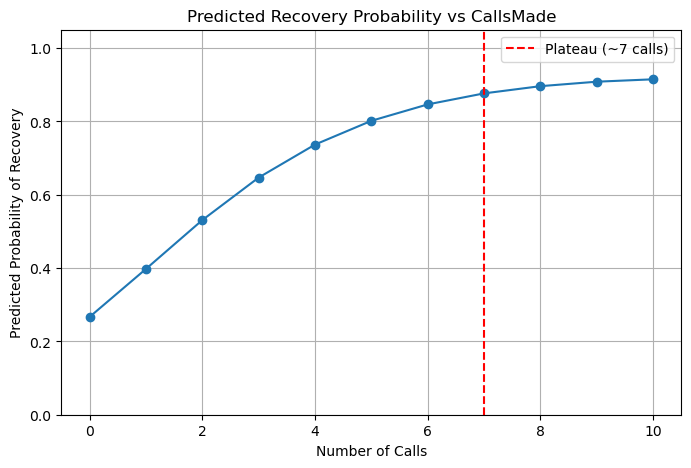

In [180]:
# 1. Add squared term for diminishing returns
calls_extended['CallsMade_sq'] = calls_extended['CallsMade']**2

# 2. Fit logistic regression model
logit_model = smf.logit("PaymentStatus ~ CallsMade + CallsMade_sq", data=calls_extended).fit()
print(logit_model.summary())

# 3. Predict probabilities for 0–10 calls
call_range = np.arange(0, 11)  # 0–10 calls
pred_df = pd.DataFrame({
    "CallsMade": call_range,
    "CallsMade_sq": call_range**2
})
pred_df["PredictedProb"] = logit_model.predict(pred_df)

# 4. Plot curve
plt.figure(figsize=(8,5))
plt.plot(pred_df["CallsMade"], pred_df["PredictedProb"], marker='o')
plt.axvline(x=7, color='r', linestyle='--', label="Plateau (~7 calls)")
plt.title("Predicted Recovery Probability vs CallsMade")
plt.xlabel("Number of Calls")
plt.ylabel("Predicted Probability of Recovery")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()
